## Imports

In [66]:
import pandas as pd
import time

from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
!pip install onnx onnxruntime optimum[onnxruntime]

## Validation data

In [67]:
from typing import List

def metrics(y_true: List[List[str]], y_pred: List[List[str]]):
    assert len(y_true) == len(y_pred)
    tp, fp, fn = 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        tp += len(set(y_true_sample) & set(y_pred_sample))
        fp += len(set(y_pred_sample) - set(y_true_sample))
        fn += len(set(y_true_sample) - set(y_pred_sample))
    
    precision = tp / (tp + fp) if tp + fp != 0 else 0.0 if tp + fn != 0.0 else 1.0
    recall = tp / (tp + fn) if tp + fn != 0 else 1.0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0.0

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
uk_geo_df = pd.read_csv("/kaggle/input/uk-ner-multibert/uk_geo_dataset_light.csv", converters={"loc_markers": eval})
ru_geo_df = pd.read_csv("/kaggle/input/multibert-ru/ru_geo_dataset_light.csv", converters={"loc_markers": eval})

In [ ]:
uk_geo_valid = uk_geo_df[uk_geo_df['is_valid'] == 1].copy()
ru_geo_valid = ru_geo_df[ru_geo_df['is_valid'] == 1].copy()
del uk_geo_df, ru_geo_df

In [68]:
def convert_loc_markers(row):
    text = row['text']
    markers = row['loc_markers']

    locs = []
    for m in markers:
        locs.append(text[m[0]:m[1]])
    
    return locs 

In [69]:
uk_geo_valid['locations'] = uk_geo_valid.progress_apply(convert_loc_markers, axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [70]:
ru_geo_valid['locations'] = ru_geo_valid.progress_apply(convert_loc_markers, axis=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

<Axes: xlabel='locations'>

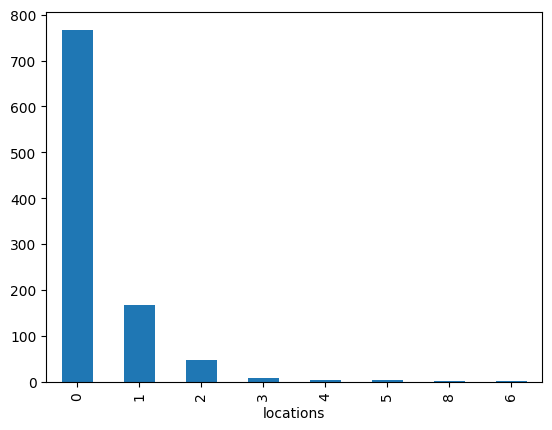

In [71]:
uk_geo_valid['locations'].apply(len).value_counts().plot.bar()

## UK model

In [ ]:
stats = []

In [ ]:
from transformers import pipeline

In [ ]:
stats_plain = {}
stats_plain['model'] = 'uk_plain'
model_uk = "/kaggle/input/uk-ner-multibert/bert-ua-loc-ner/checkpoint-14096"
classifier_uk = pipeline("token-classification", model=model_uk, aggregation_strategy="simple")

In [ ]:
start = time.time()
preds = classifier_uk(uk_geo_valid['text'].to_list())
stats_plain['time'] = time.time() - start

In [ ]:
preds_locations = []
for pred in preds:
    locs = []
    for loc in pred:
        locs.append(loc['word'])
    preds_locations.append(locs)

In [ ]:
uk_geo_valid['locations_pred'] = preds_locations

In [ ]:
stats_plain.update(metrics(uk_geo_valid['locations'], uk_geo_valid['locations_pred']))

In [ ]:
stats_plain

In [ ]:
stats.append(stats_plain)

In [ ]:
pd.DataFrame.from_records(stats)

### ONNX Conversion

In [ ]:
from optimum.onnxruntime import ORTModelForTokenClassification
from transformers import AutoTokenizer

save_directory = "/kaggle/working/model_uk_onnx"

# Load a model from transformers and export it to ONNX
ort_model = ORTModelForTokenClassification.from_pretrained(model_uk, export=True)
tokenizer = AutoTokenizer.from_pretrained(model_uk)

# Save the onnx model and tokenizer
ort_model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

In [ ]:
from optimum.pipelines import pipeline
from optimum.onnxruntime import ORTModelForTokenClassification

In [ ]:
model = ORTModelForTokenClassification.from_pretrained("/kaggle/working/model_uk_onnx")
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/model_uk_onnx")

In [ ]:
classifier_uk = pipeline("token-classification", model=model, tokenizer=tokenizer, accelerator="ort", aggregation_strategy="simple")

In [ ]:
stats_onnx = {}
stats_onnx['model'] = 'uk_onnx'

In [ ]:
start = time.time()
preds = classifier_uk(uk_geo_valid['text'].to_list())
stats_onnx['time'] = time.time() - start

In [ ]:
preds_locations = []
for pred in preds:
    locs = []
    for loc in pred:
        locs.append(loc['word'])
    preds_locations.append(locs)

In [ ]:
uk_geo_valid['locations_pred_onnx'] = preds_locations

In [ ]:
stats_onnx.update(metrics(uk_geo_valid['locations'], uk_geo_valid['locations_pred_onnx']))

In [ ]:
stats.append(stats_onnx)

In [ ]:
pd.DataFrame.from_records(stats)

### Graph optimization

In [ ]:
from transformers import AutoTokenizer
from optimum.onnxruntime import (
    AutoOptimizationConfig,
    ORTModelForTokenClassification,
    ORTOptimizer
)
from optimum.onnxruntime.configuration import OptimizationConfig
from optimum.pipelines import pipeline

model_id = "/kaggle/working/model_uk_onnx"
save_dir = "/kaggle/working/model_uk_onnx_optimized"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = ORTModelForTokenClassification.from_pretrained(model_id)

# Load the optimization configuration detailing the optimization we wish to apply
optimization_config = AutoOptimizationConfig.O2()
optimizer = ORTOptimizer.from_pretrained(model)

optimizer.optimize(save_dir=save_dir, optimization_config=optimization_config)
model = ORTModelForTokenClassification.from_pretrained(save_dir)

In [ ]:
classifier_uk = pipeline("token-classification", model=model, tokenizer=tokenizer, accelerator="ort", aggregation_strategy="simple")

In [ ]:
stats_onnx_optimized = {}
stats_onnx_optimized['model'] = 'uk_onnx_optimized'

In [ ]:
start = time.time()
preds = classifier_uk(uk_geo_valid['text'].to_list())
stats_onnx_optimized['time'] = time.time() - start

In [ ]:
preds_locations = []
for pred in preds:
    locs = []
    for loc in pred:
        locs.append(loc['word'])
    preds_locations.append(locs)

In [ ]:
uk_geo_valid['locations_pred_onnx_optimized'] = preds_locations

In [ ]:
stats_onnx_optimized.update(metrics(uk_geo_valid['locations'], uk_geo_valid['locations_pred_onnx_optimized']))

In [ ]:
stats.append(stats_onnx_optimized)

In [ ]:
pd.DataFrame.from_records(stats)

### Quantization

In [ ]:
from transformers import AutoTokenizer
from optimum.onnxruntime import (
    AutoQuantizationConfig,
    QuantizationConfig,
    ORTModelForTokenClassification,
    ORTQuantizer
)
from optimum.pipelines import pipeline

# Load the tokenizer and export the model to the ONNX format
model_id = "/kaggle/working/model_uk_onnx"
save_dir = "/kaggle/working/model_uk_onnx_quantized"

model = ORTModelForTokenClassification.from_pretrained(model_id)

In [ ]:
from onnxruntime.quantization import QuantType, QuantFormat, QuantizationMode

In [ ]:
qconfig = QuantizationConfig(
    format=QuantFormat.QOperator,
    is_static=False,
    mode=QuantizationMode.IntegerOps,
    activations_dtype=QuantType.QUInt8,
    weights_dtype=QuantType.QUInt8,
    per_channel=True,
)
# qconfig = AutoQuantizationConfig.avx512_vnni(is_static=False)

In [ ]:
quantizer = ORTQuantizer.from_pretrained(model)

# Apply dynamic quantization and save the resulting model
quantizer.quantize(save_dir=save_dir, quantization_config=qconfig)
# Load the quantized model from a local repository
model = ORTModelForTokenClassification.from_pretrained(save_dir)

In [ ]:
text = uk_geo_valid['text'].loc[304]
inputs = tokenizer(text, return_tensors="pt")

In [ ]:
classifier_uk = pipeline("token-classification", model=model, tokenizer=tokenizer, accelerator="ort", aggregation_strategy="simple")

In [ ]:
stats_onnx_quantized = {}
stats_onnx_quantized['model'] = 'uk_onnx_quantized'

In [ ]:
start = time.time()
preds = classifier_uk(uk_geo_valid['text'].to_list())
stats_onnx_quantized['time'] = time.time() - start

In [ ]:
preds_locations = []
for pred in preds:
    locs = []
    for loc in pred:
        locs.append(loc['word'])
    preds_locations.append(locs)

In [ ]:
uk_geo_valid['locations_pred_onnx_quantized'] = preds_locations

In [ ]:
stats_onnx_quantized.update(metrics(uk_geo_valid['locations'], uk_geo_valid['locations_pred_onnx_quantized']))

In [ ]:
stats.append(stats_onnx_quantized)

In [ ]:
pd.DataFrame.from_records(stats)

### Quantization of optimized model

In [ ]:
from transformers import AutoTokenizer
from optimum.onnxruntime import (
    AutoQuantizationConfig,
    QuantizationConfig,
    ORTModelForTokenClassification,
    ORTQuantizer
)
from optimum.pipelines import pipeline

# Load the tokenizer and export the model to the ONNX format
model_id = "/kaggle/working/model_uk_onnx_optimized"
save_dir = "/kaggle/working/model_uk_onnx_opt_quant"

model = ORTModelForTokenClassification.from_pretrained(model_id)

In [ ]:
from onnxruntime.quantization import QuantType, QuantFormat, QuantizationMode

In [ ]:
qconfig = QuantizationConfig(
    format=QuantFormat.QOperator,
    is_static=False,
    mode=QuantizationMode.IntegerOps,
    activations_dtype=QuantType.QUInt8,
    weights_dtype=QuantType.QUInt8,
    per_channel=True,
)
# qconfig = AutoQuantizationConfig.avx512_vnni(is_static=False)

In [ ]:
quantizer = ORTQuantizer.from_pretrained(model)

# Apply dynamic quantization and save the resulting model
quantizer.quantize(save_dir=save_dir, quantization_config=qconfig)
# Load the quantized model from a local repository
model = ORTModelForTokenClassification.from_pretrained(save_dir)

In [ ]:
text = uk_geo_valid['text'].loc[304]
inputs = tokenizer(text, return_tensors="pt")

In [ ]:
classifier_uk = pipeline("token-classification", model=model, tokenizer=tokenizer, accelerator="ort", aggregation_strategy="simple")

In [ ]:
stats_onnx_opt_quant = {}
stats_onnx_opt_quant['model'] = 'uk_onnx_opt_quant'

In [ ]:
start = time.time()
preds = classifier_uk(uk_geo_valid['text'].to_list())
stats_onnx_opt_quant['time'] = time.time() - start

In [ ]:
preds_locations = []
for pred in preds:
    locs = []
    for loc in pred:
        locs.append(loc['word'])
    preds_locations.append(locs)

In [ ]:
uk_geo_valid['locations_pred_onnx_opt_quant'] = preds_locations

In [ ]:
stats_onnx_opt_quant.update(metrics(uk_geo_valid['locations'], uk_geo_valid['locations_pred_onnx_opt_quant']))

In [ ]:
stats.append(stats_onnx_opt_quant)

In [72]:
pd.DataFrame.from_records(stats)

,model,time,precision,recall,f1
0,uk_plain,103.403798,0.838068,0.883234,0.860058
1,uk_onnx,74.409132,0.838068,0.883234,0.860058
2,uk_onnx_optimized,70.853269,0.838068,0.883234,0.860058
3,uk_onnx_quantized,60.097228,0.831884,0.859281,0.845361
4,uk_onnx_opt_quant,63.317703,0.827988,0.850299,0.838996
